In [34]:
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt

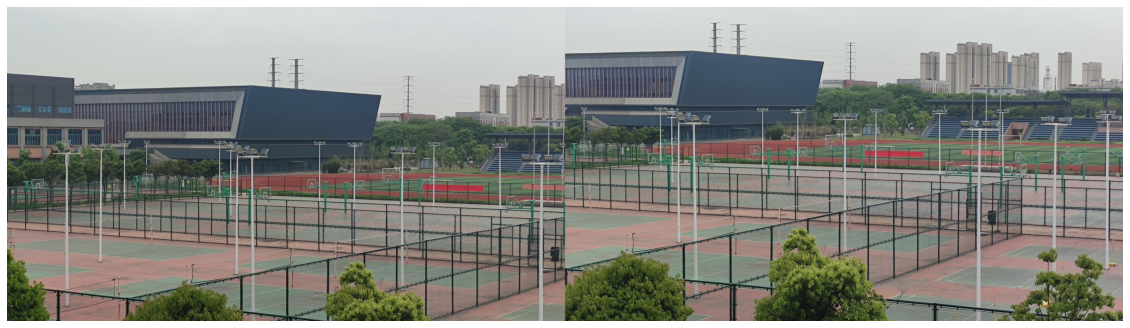

In [115]:
#读入图像
fst = r"image\example1\1.jpg"
scd = r"image\example1\2.jpg"

path1,path2=[fst,scd]
img1=cv2.imread(path1)
img2=cv2.imread(path2)

img3 = np.concatenate((img1, img2), axis = 1)

#显示未拼接图片
fig = plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [116]:
#提取灰度图像
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#SIFT检测特征点
descriptor = cv2.SIFT_create()
kp1, feat1 = descriptor.detectAndCompute(gray1, None)
kp2, feat2 = descriptor.detectAndCompute(gray2, None)
kp1 = np.float32([kp.pt for kp in kp1])
kp2 = np.float32([kp.pt for kp in kp2])

#KNN特征匹配
matcher=cv2.FlannBasedMatcher()
rawMatches = matcher.knnMatch(feat1, feat2, 2)
matches = []
for m in rawMatches:
    if len(m) == 2 and m[0].distance < m[1].distance * 0.75:
        matches.append((m[0].trainIdx, m[0].queryIdx))

#特征点匹配及过滤
if len(matches) > 4:
    ptsA = np.float32([kp1[i] for (_, i) in matches])
    ptsB = np.float32([kp2[i] for (i, _) in matches])
    retval, _ = cv2.findHomography(ptsB, ptsA, cv2.RANSAC, 3.0)

In [117]:
# 计算混合渐变
relt = cv2.warpPerspective(img2, retval, (img1.shape[1] + img2.shape[1], img1.shape[0]))
relt[0:img1.shape[0], 0:img1.shape[1]] = img1
mask = np.zeros((img1.shape[0], img1.shape[1]), dtype=np.uint8)
mask[:, img1.shape[1] - 40:] = 255
relt = cv2.seamlessClone(img1, relt, mask, (img1.shape[1], img1.shape[0] // 2), cv2.NORMAL_CLONE)

In [110]:
#凸点检测（可选）
gray3 = cv2.cvtColor(relt, cv2.COLOR_BGR2GRAY)
contours,_ = cv2.findContours(gray3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
hull = cv2.convexHull(largest_contour)
hull_points = []
for point in hull:
    hull_points.append(point[0])
bounding_rect = cv2.boundingRect(contours[0])
x, y, w, h = bounding_rect
rhpoint = None
rbpoint = None
h = relt.shape[0] - 1
for point in hull_points:
    if rhpoint is None or (point[1] == 0 and (rhpoint[1] == 0 and point[0] > rhpoint[0])):
        rhpoint = point
    if rbpoint is None or (point[1] == h and (rbpoint[1] != h and point[0] > rbpoint[0])):
        rbpoint = point

In [111]:
#不裁剪图像，直接应用透视变换（执行凸点检测后选择执行该部分）
original_points = np.float32([[0, 0], rhpoint, rbpoint, [0, h]])
corrected_points = np.float32([[0, 0], [rbpoint[0], 0], rbpoint, [0, h]])
perspective_matrix = cv2.getPerspectiveTransform(original_points, corrected_points)

#应用透视变换
output_image = cv2.warpPerspective(relt, perspective_matrix, (relt.shape[1], relt.shape[0]))

In [113]:
 #裁剪图像（执行凸点检测后选择执行该部分）
trimmed_image = relt[y:y+h, 0:x+w]
original_points=np.float32([[0,0],rhpoint,rbpoint,[0,h]])
corrected_points=np.float32([[0, 0], [rbpoint[0], 0],rbpoint ,[0,h] ])
perspective_matrix = cv2.getPerspectiveTransform(original_points, corrected_points)

#应用透视变换
relt = cv2.warpPerspective(trimmed_image, perspective_matrix, (trimmed_image.shape[1], trimmed_image.shape[0]))

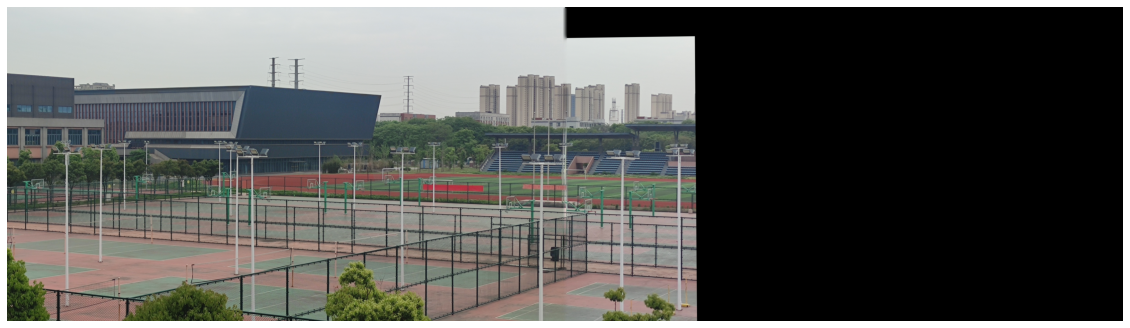

In [118]:
#结果输出
cv2.imwrite(r'stitch_image.jpg', relt)
relt=cv2.resize(relt,(relt.shape[1]//2,relt.shape[0]//2))

fig = plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(relt, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
# cv2.imshow("Result",relt)
# cv2.waitKey(0)